In [1]:
from src import data_loader as dl
from src.models import ExactGPModel
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt


/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing Steps

In [22]:
df_location = dl.load_data('pv_data', 'system_location.csv')
df_pv = dl.load_data('pv_data', 'pv.netcdf')

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 19 m : 13 sec



In [3]:
# Set the parameters for data preprocessing
THRESHOLD = 0.05
DAY_MIN = 8
DAY_MAX = 16

In [25]:
df_location = dl.set_index(df_location)

# align pv systems to locations from metadata and the pv data
df_location, df_pv = dl.align_pv_systems(df_location=df_location, 
                                         df_pv=df_pv)

# scale by capacity
df_pv = dl.scale_by_capacity(df_pv, df_location)

# drop systems producing over night
df_pv = dl.drop_night_production(df_pv=df_pv,
                                 threshold=THRESHOLD)

# get daily production from 8am to 4pm
df_pv = dl.daily_production(df_pv=df_pv,
                            day_min=DAY_MIN,
                            day_max=DAY_MAX)

# remove systems with zero production for more than 5 percent of the time
df_pv = dl.remove_zero_production(df_pv=df_pv,
                                  thresh=THRESHOLD)


Dropping 54 systems producing over night


In [26]:
datetime = df_pv.index
df_pv = df_pv.reset_index(drop=True)

df_location, df_pv = dl.align_pv_systems(df_pv=df_pv,
                                         df_location=df_location)
df_pv['datetime'] = datetime

In [27]:
dl.save_csv(df_pv, 'pv_data', 'pv_data_clean.csv')
dl.save_csv(df_location, 'pv_data', 'location_data_clean.csv')

## Example of using preprocessed data

In [9]:
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 10
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 30
RADIUS = 0.3
COORDS = (54.95074, -1.5278)

In [14]:
df_pv = dl.load_data('pv_data', 'pv_data_clean.csv')
df_location = dl.load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [15]:
df_location = dl.set_index(df_location)
datetime = df_pv['datetime']

In [16]:
systems = dl.find_nearby_systems(df_location, 
                                     lat=COORDS[0],
                                     lon=COORDS[1],
                                     radius=RADIUS)

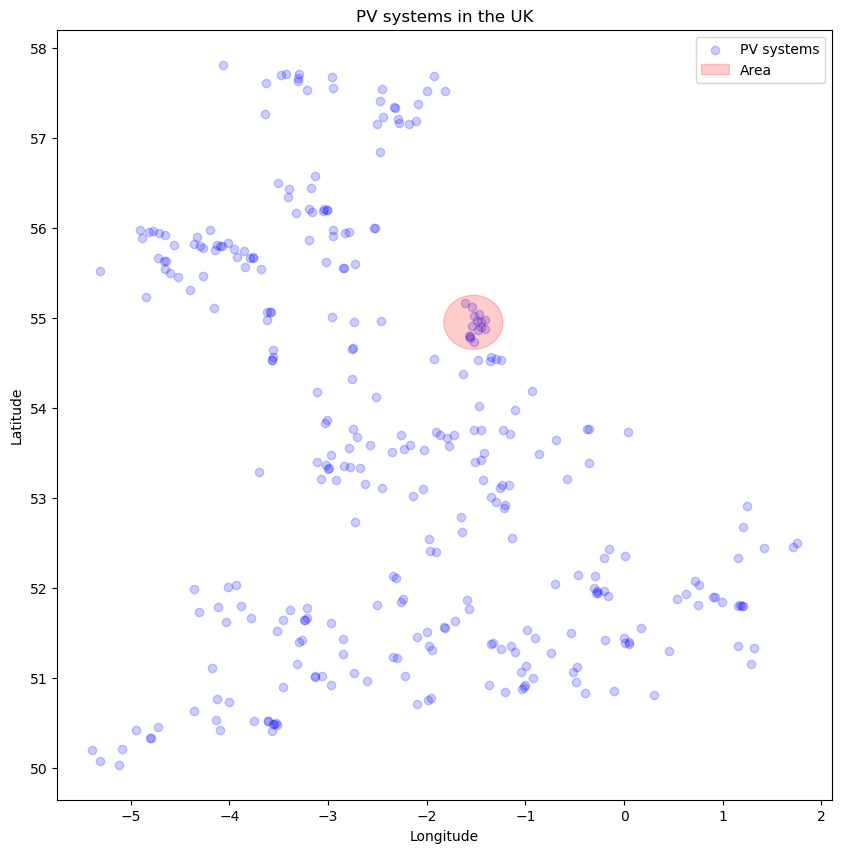

In [17]:
from src.plotting import plot_grid
plot_grid(df_location, COORDS, RADIUS)

## Automate process from here to finished data given to GP model

In [3]:
from src.data_loader import DataLoader

In [29]:
loader = DataLoader(n_days=N_DAYS,
                    day_init=35,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')



==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [30]:
time, y = loader.get_time_series()

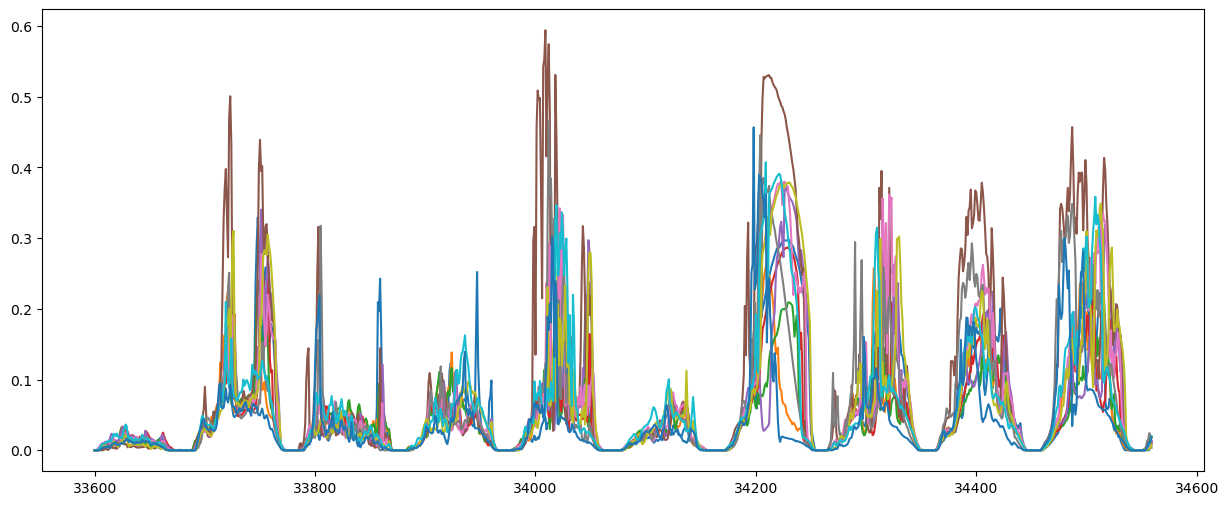

In [31]:
# set figure size
plt.figure(figsize=(15, 6))

plt.plot(time, y);

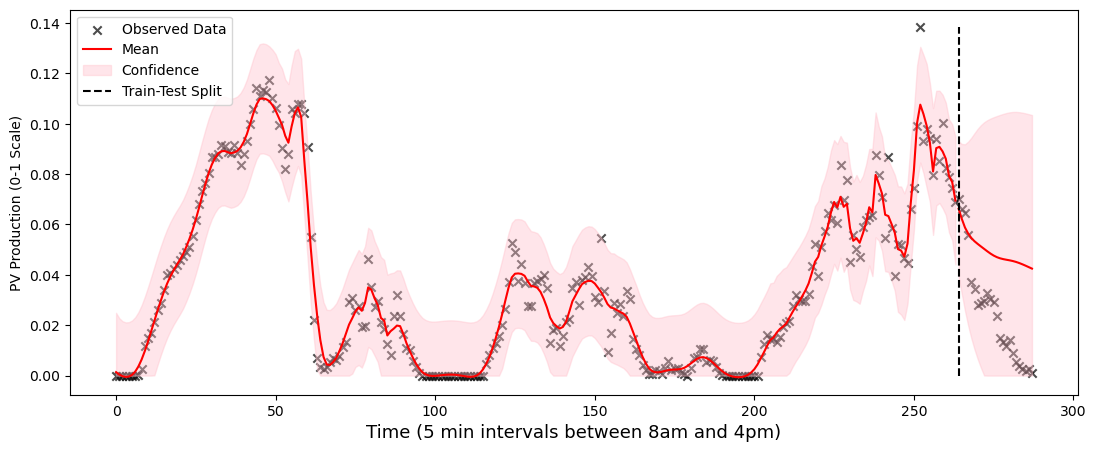

In [141]:
observed_pred, observed_pred_train = model.predict(covars_test)

# plot predictions
plt.figure(figsize=(13, 5))

plt.scatter(covars[:,0], y_train, marker='x', color='black', alpha=0.7, label='Observed Data')
plt.scatter(covars_test[:,0], y_test, marker='x', color='black', alpha=0.7)

plt.plot(covars[:,0], observed_pred_train.mean, color='r', label='Mean')

lower, upper = observed_pred_train.confidence_region()
# clip the lower and upper confidence region to avoid negative values and greater than 1
lower = np.clip(lower, 0, 1)
upper = np.clip(upper, 0, 1)
plt.fill_between(covars[:,0], lower, upper, alpha=0.4, color='pink', label='Confidence')



plt.plot(covars_test[:,0], observed_pred.mean, color='r')
lower, upper = observed_pred.confidence_region()

lower = np.clip(lower, 0, 1)
upper = np.clip(upper, 0, 1)

plt.fill_between(covars_test[:,0], lower, upper, alpha=0.4, color='pink')
plt.vlines(x= len(covars[:,0]), ymin=0, ymax=max(y_train.max(), y_test.max()), 
           color='black', linestyle='--', label='Train-Test Split')


plt.legend()

plt.xlabel('Time (5 min intervals between 8am and 4pm)', fontsize=13)
plt.ylabel('PV Production (0-1 Scale)')

plt.show();